In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 500

In [3]:
final_remove_country_list = ['Aruba', 'Bermuda', 'Cayman Islands', 'Guam', 'Puerto Rico']
final_rename_dict = {'Antigua':'Antigua and Barbuda', 
                     'Bosnia Herzogovinia':'Bosnia and Herzegovina', 
                     'British Virgin Isla':'British Virgin Islands', 
                     'Burma(Myanmar)':'Myanmar', 
                     'Cape Verde':'Cabo Verde', 
                     'Columbia':'Colombia', 
                     'Czech Republic':'Czechia', 
                     'Macedonia':'North Macedonia', 
                     'Russian Federation':'Russia', 
                     'Turkey':'Türkiye', 
                     'UK':'United Kingdom', 
                     'USA':'United States', 
                     'United Arab Emirate':'United Arab Emirates'}

# Datasets Representativeness

In [4]:
df_reference = pd.read_csv('outputFiles/770k_Personality_Measurements.csv')
df_reference['COUNTRY'] = df_reference['COUNTRY'].replace(final_rename_dict)
df_country = pd.DataFrame(df_reference['COUNTRY'].value_counts()).reset_index()
df_country.columns = ['COUNTRY', 'Counts']

df_age = pd.DataFrame(df_reference['AGE'].value_counts()).reset_index()
df_age.columns = ['AGE', 'Counts']
df_age = df_age.sort_values('AGE')

df_year2010 = df_reference[(df_reference['COUNTRY'].isin(df_avg_input['COUNTRY'])) & (df_reference['YR'] == 2010)]
df_age_2010 = pd.DataFrame(df_year2010['AGE'].value_counts()).reset_index()
df_age_2010.columns = ['AGE', 'Counts']
df_age_2010 = df_age_2010.sort_values('AGE')

df_sex_ratio = pd.DataFrame(df_year2010.groupby('COUNTRY')['SEX'].value_counts(normalize = True))
df_sex_ratio.columns = ['percent']
df_sex_ratio = df_sex_ratio.reset_index()
df_sex_ratio = pd.pivot_table(df_sex_ratio, values='percent', index=['COUNTRY'], columns=['SEX'])
df_sex_ratio['Ratio'] = df_sex_ratio.iloc[:,0]/df_sex_ratio.iloc[:,1]
df_sex_ratio = df_sex_ratio.reset_index()
df_sex_ratio['Ratio'].mean()

In [21]:
import plotly.express as px

fig = px.bar(df_age, x='AGE', y='Counts', template = 'plotly_white', color_discrete_sequence = ['rgb(0, 0, 100)'])
fig.show()

In [22]:
fig = px.bar(df_age_2010, x='AGE', y='Counts', template = 'plotly_white', color_discrete_sequence = ['rgb(0, 0, 100)'])
fig.show()

In [50]:
fig = px.bar(df_year2010.groupby('COUNTRY').agg({'AGE':'median'}).reset_index().sort_values('AGE'), x='COUNTRY', y='AGE', template = 'plotly_white')
fig.show()


In [54]:
fig = px.bar(df_year2010.groupby('COUNTRY').agg({'SEQ':'count'}).reset_index().sort_values('SEQ', ascending = False).rename(columns = {'SEQ':'Counts'}), x='COUNTRY', y='Counts', template = 'plotly_white', color_discrete_sequence = ['orange'])
fig.show()

In [59]:
fig = px.bar(df_sex_ratio.sort_values('Ratio', ascending = False), x='COUNTRY', y='Ratio', template = 'plotly_white', color_discrete_sequence = ['lightgreen'])
fig.show()

# Hero Figure 4

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px

In [8]:
df_diversity_index = pd.read_csv('outputFiles/Personality_Index_Summary.csv')
df_diversity_index_all = df_diversity_index[~df_diversity_index['trans_median_pairwise'].isna()]

df_diversity_index_all = df_diversity_index_all[~df_diversity_index_all['COUNTRY'].isna()]
df_diversity_index_all = df_diversity_index_all.drop_duplicates('COUNTRY')
df_diversity_index_all.shape

df_avg_eco = pd.read_csv('sourceFiles/GDP per person employed (constant 2021 PPP $) 2005-2023 - Correlation between 21 and Avg 2005-2023.csv')
df_avg_eco = df_avg_eco[['Country Name', 'Series Name', '2005-2023 Average']]
df_avg_eco = df_avg_eco[~df_avg_eco['Series Name'].isna()]
df_avg_eco.rename(columns = {'Country Name':'COUNTRY', '2005-2023 Average':'GDP per person employed (constant 2005-2023 PPP $)'}, inplace = True)
rename_dict = {'Antigua and Barbuda':'Antigua',
               'Bahamas, The':'Bahamas',
               'Bosnia and Herzegovina':'Bosnia Herzogovinia',
               'British Virgin Islands':'British Virgin Isla',
               'Brunei Darussalam':'Brunei',
               'Myanmar':'Burma(Myanmar)',
               'Cabo Verde':'Cape Verde',
               'Colombia':'Columbia',
               'Czechia':'Czech Republic',
               'Egypt, Arab Rep.':'Egypt',
               'Iran, Islamic Rep.':'Iran',
               'North Macedonia':'Macedonia',
               'Slovak Republic':'Slovakia',
               'Korea, Rep.':'South Korea',
               'Syrian Arab Republic':'Syria',
               'Turkiye':'Turkey',
               'United Kingdom':'UK',
               'United States':'USA',
               'United Arab Emirates':'United Arab Emirate',
               'Venezuela, RB':'Venezuela',
               'Viet Nam':'Vietnam',
               'Yemen, Rep.':'Yemen'}
df_avg_eco['COUNTRY'] = df_avg_eco['COUNTRY'].replace(rename_dict)

df_avg_eco['GDP per person employed (constant 2005-2023 PPP $)'] = df_avg_eco['GDP per person employed (constant 2005-2023 PPP $)'].astype(float)
df_avg_eco['ln GDP per person employed (constant 2005-2023 PPP $)'] = np.log(df_avg_eco['GDP per person employed (constant 2005-2023 PPP $)'])
df_avg_eco['Sigmoid GDP per person employed (constant 2005-2023 PPP $)'] = df_avg_eco['GDP per person employed (constant 2005-2023 PPP $)'].apply(lambda x: 1/(1 + np.exp(-x)))
df_avg_eco.drop(columns = ['Series Name'], inplace = True)

df_avg_input = df_diversity_index_all[df_diversity_index_all['COUNTRY'].isin(df_avg_eco['COUNTRY'])].merge(df_avg_eco, how = 'left', left_on = 'COUNTRY', right_on = 'COUNTRY')

df_avg_input['Personality Diversity'] = df_avg_input['trans_median_pairwise']
df_avg_input = df_avg_input[~df_avg_input['COUNTRY'].isin(['Thailand'])]
df_avg_input.reset_index(drop = True, inplace = True)
df_avg_input = df_avg_input[~df_avg_input['COUNTRY'].isin(final_remove_country_list)]
df_avg_input['COUNTRY'] = df_avg_input['COUNTRY'].replace(final_rename_dict)
df_avg_input.shape

(135, 22)

In [624]:
df_regression = df_avg_input.copy()

ln_eco_features_rename = {'ln GDP per person employed (constant 2005-2023 PPP $)':'eco_feature1',
                          'Personality Diversity':'personality_index'}

df_regression = df_regression.rename(columns = ln_eco_features_rename)
df_regression = df_regression[~df_regression['eco_feature1'].isna()]
df_regression.shape

(129, 22)

In [625]:
feature_y = 'eco_feature1'
feature_x = 'personality_index'
linear_model = smf.ols('{0} ~ {1}'.format(feature_y, feature_x), data=df_regression).fit()
para_model = smf.ols('{0} ~ {1} + I(-{1}**2)'.format(feature_y, feature_x), data=df_regression).fit()

x = np.arange(df_regression[feature_x].min(), df_regression[feature_x].max(), 0.0001)

y_linear = [linear_model.params['Intercept'] + linear_model.params['personality_index'] * i for i in x]

y_para = [para_model.params['Intercept'] + para_model.params['personality_index'] * i - (para_model.params['I(-personality_index ** 2)'] * i**2) for i in x]

df_linear = pd.DataFrame([x, y_linear]).transpose()
df_linear.columns = [feature_x, 'linear_y']
df_para = pd.DataFrame([x, y_para]).transpose()
df_para.columns = [feature_x, 'para_y']

In [626]:
print ("R-squared of Linear model: {0}".format(linear_model.rsquared))
print ("p-value of Linear model: {0}".format(linear_model.f_pvalue))

print ("R-squared of Parabolic model: {0}".format(para_model.rsquared))
print ("p-value of Parabolic model: {0}".format(para_model.f_pvalue))

R-squared of Linear model: 0.20870503708504706
p-value of Linear model: 5.2717321367828333e-08
R-squared of Parabolic model: 0.24412305222933128
p-value of Parabolic model: 2.199983103958305e-08


In [282]:
df_regression_annotation = df_regression.copy()
show_list = ['Cambodia', 'Uganda', 'Kenya', 'Bangladesh', 'Nigeria', 'Zimbabwe', 'Afghanistan', 'Honduras', 
             'Sudan', 'Jamaica', 'Morocco', 'Albania', 'Georgia', 'Angola', 'Poland', 'China', 'Brazil', 
             'Colombia', 'Chile', 'Lebanon', 'Egypt', 'South Korea', 'Saudi Arabia', 'Romania', 'Argentina', 
             'New Zealand', 'Japan', 'United Kingdom', 'Austria', 'United States', 'Italy', 'Singapore', 
             'Luxembourg', 'Ireland']
df_regression_annotation = df_regression_annotation[df_regression_annotation['COUNTRY'].isin(show_list)]
df_regression_annotation = df_regression_annotation[[feature_x,feature_y,'COUNTRY']]
df_regression_annotation.columns = ['x','y','text']
df_regression_annotation['ax'] = 50
df_regression_annotation['ay'] = 10
annotations = df_regression_annotation.to_dict(orient = 'record')
df_regression['Color_Flag'] = np.nan
df_regression.loc[df_regression['COUNTRY'].isin(show_list), 'Color_Flag'] = 'Yes'
df_regression['Color_Flag'] = df_regression['Color_Flag'].fillna('No')
df_regression['Annotation'] = np.nan
df_regression.loc[df_regression['COUNTRY'].isin(show_list), 'Annotation'] = df_regression.loc[df_regression['COUNTRY'].isin(show_list), 'Annotation'].fillna(df_regression.loc[df_regression['COUNTRY'].isin(show_list), 'COUNTRY'])
df_regression['Annotation'] = df_regression['Annotation'].fillna('')
df_regression = pd.concat([df_regression[df_regression['Color_Flag'] == 'No'], 
                           df_regression[df_regression['Color_Flag'] == 'Yes']])


/opt/anaconda3/envs/my_pymc_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.



In [283]:
fig = px.scatter(df_regression, x=feature_x, y=feature_y, color = 'Color_Flag', text = 'Annotation', log_x=True,
                 template = 'simple_white', color_discrete_map = {'Yes':'#808080','No':'#C0C0C0'},
#                  trendline="ols", color_discrete_sequence = ['grey'], trendline_color_override = 'blue', 
                 labels={
                     feature_x: "Personality Diversity Index",
                     feature_y: "ln GDP per person employed (constant 2005-2023 PPP $)"
                 }, width=700, height=500)
fig.layout.showlegend = False
fig.add_traces(px.line(df_linear, x=feature_x, y="linear_y", template = 'simple_white', color_discrete_sequence = ['blue']).data)
fig.add_traces(px.line(df_para, x=feature_x, y="para_y", template = 'simple_white', color_discrete_sequence = ['red']).data)

fig.update_traces(textposition='top center')

fig.update_layout(

    margin=dict(r=0, b=0, t = 0, l=0 ,pad=0)
)

fig.show()


# Figure 2

In [19]:
df_cluster_heatmap = pd.read_csv('outputFiles/US_Personality_Diversity_8_Clusters_Heatmap.csv')
df_cluster_heatmap = df_cluster_heatmap.set_index('index')
df_cluster_heatmap.columns = ['Pioneer', 'Translator', 'Pathfinder', 'Advisor', 'Yearner', 'Leader', 'Uniter', 'Strategist']
df_cluster_heatmap.index = ["{0} ({1})".format(i.split('_')[1].strip(), i.split('_')[0].strip()) for i in df_cluster_heatmap.index]

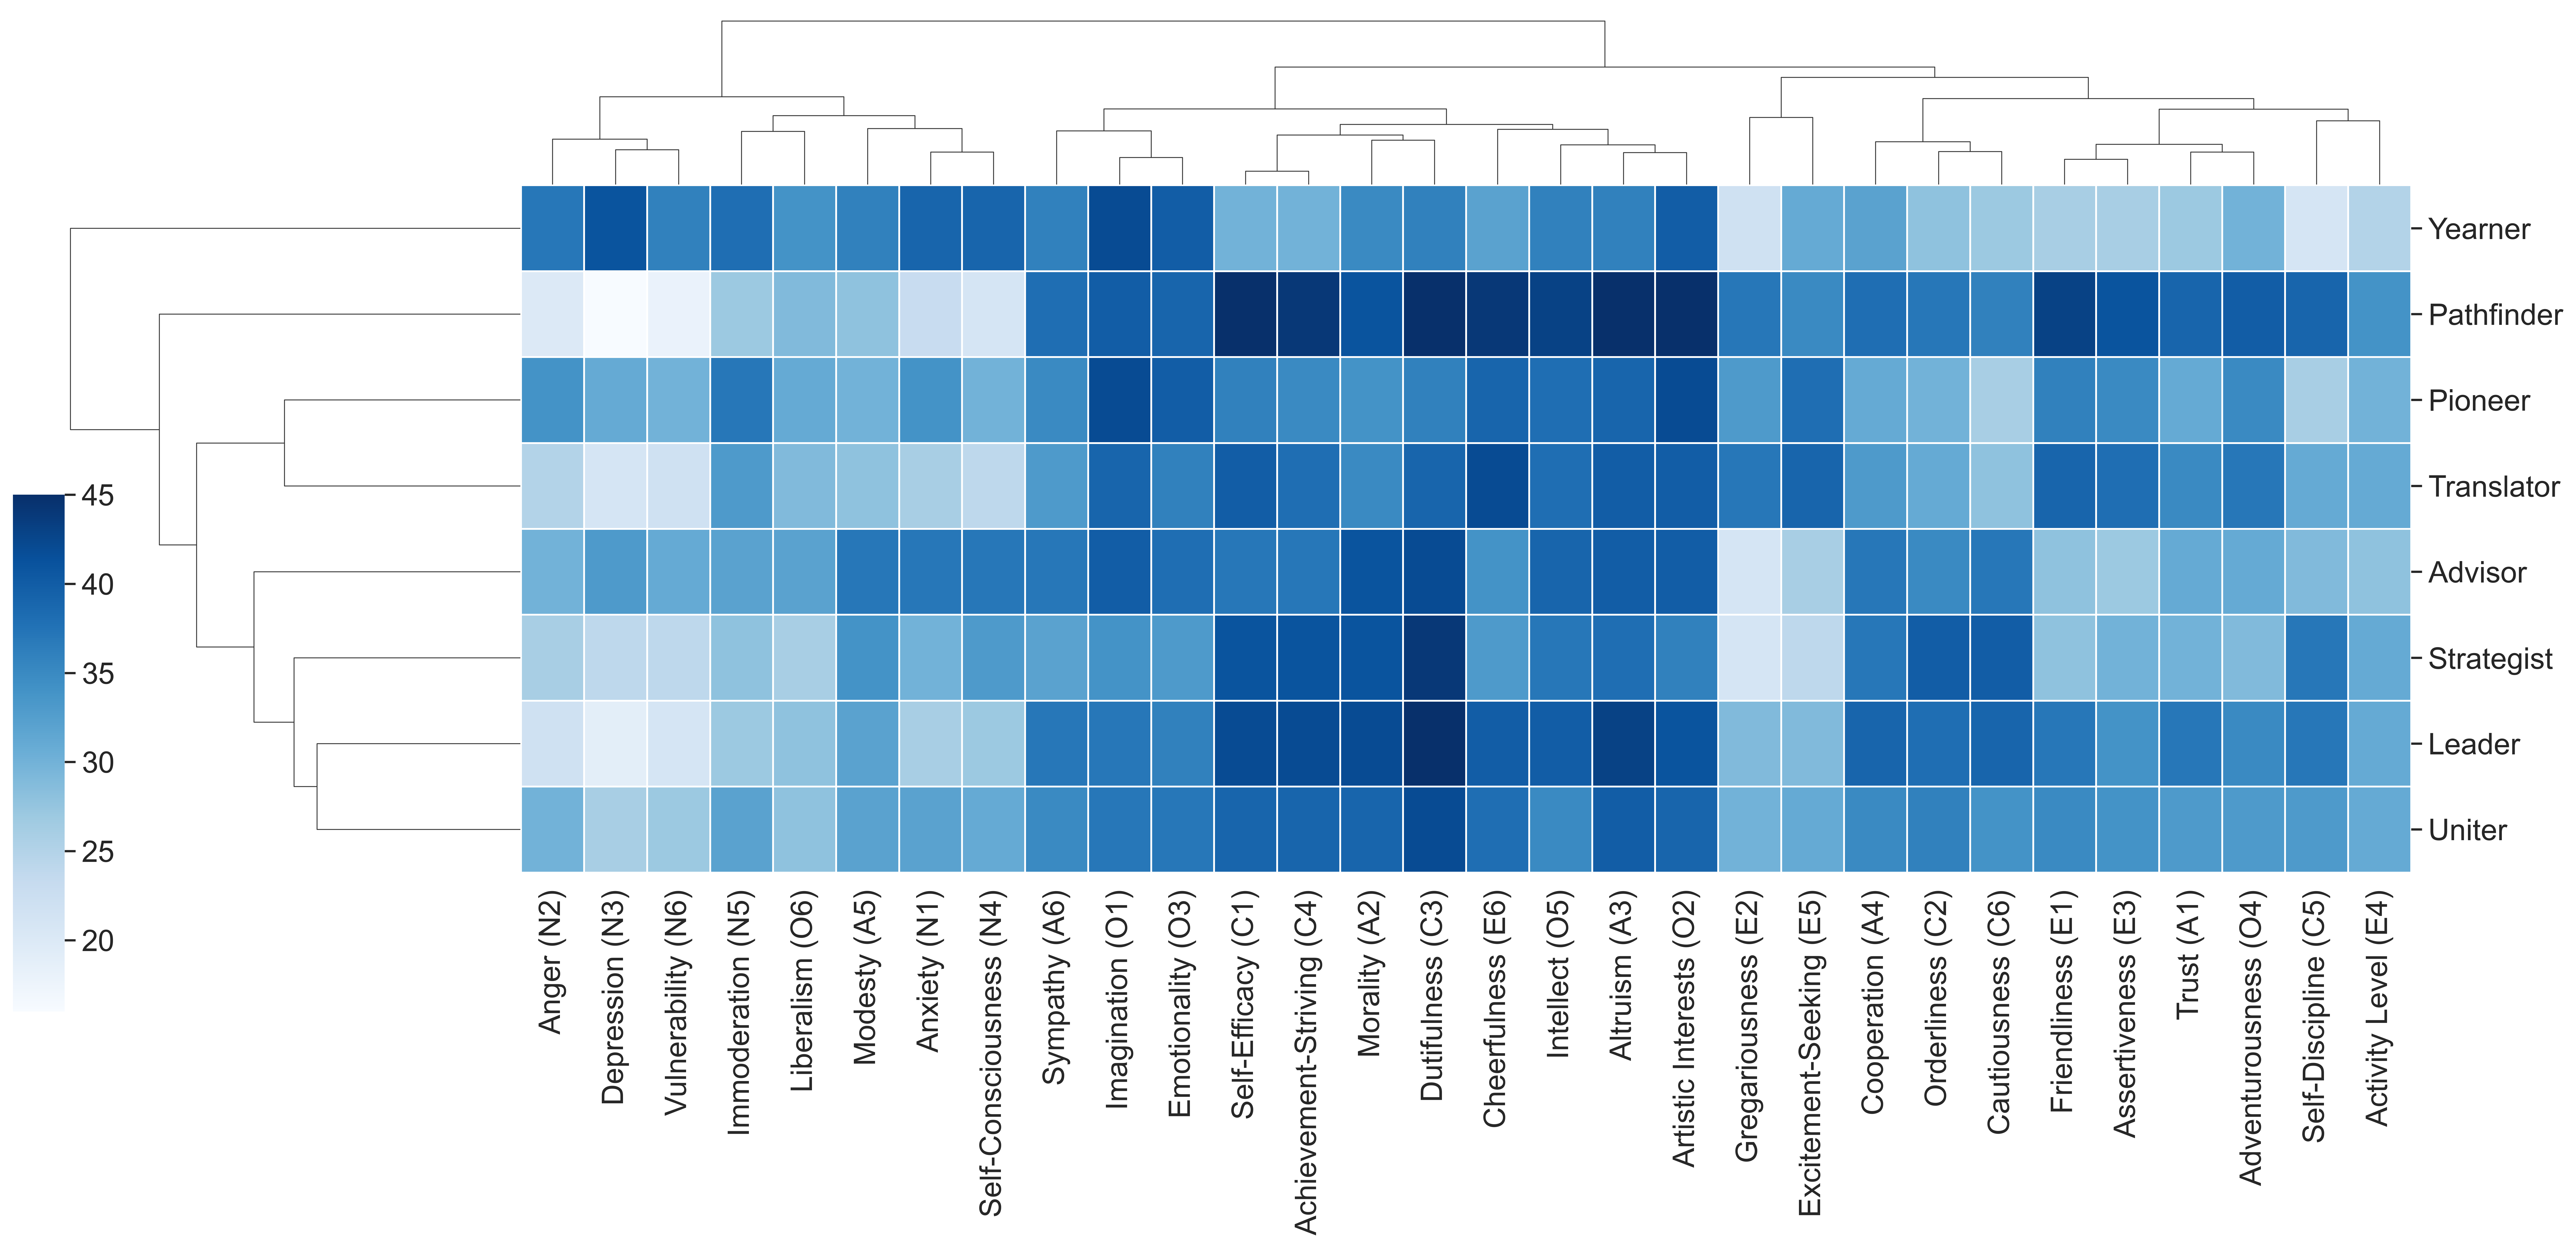

In [20]:
sns.set(font_scale = 1.5)
im = sns.clustermap(df_cluster_heatmap.T, cmap='Blues', linewidth = 1, figsize=(20, 10), 
                    cbar_pos=(0, .2, .02, .4))
ax = im.ax_heatmap
ax.set_ylabel("")
ax.set_xlabel("")
plt.show()
fig = ax.get_figure()


# Figure 3

In [288]:
df_pairwise_samples = pd.read_csv('outputFiles/Pairwise_Samples.csv')
df_pairwise_samples['trans_cosine_distance'] = np.log(df_pairwise_samples['cosine_distance']).tolist()
df_pairwise_samples = df_pairwise_samples[(df_pairwise_samples['cosine_distance'] != 0)]
df_pairwise_samples['COUNTRY'] = df_pairwise_samples['COUNTRY'].replace(final_rename_dict)

df_diversity_index = pd.read_csv('outputFiles/Personality_Index_Summary.csv')
df_diversity_index_all = df_diversity_index[~df_diversity_index['trans_median_pairwise'].isna()]
df_diversity_index_all['COUNTRY'] = df_diversity_index_all['COUNTRY'].replace(final_rename_dict)
df_diversity_index_all = df_diversity_index_all[~df_diversity_index_all['COUNTRY'].isna()]
df_diversity_index_all = df_diversity_index_all.drop_duplicates('COUNTRY')
print (df_diversity_index_all.shape)
df_diversity_index_all = df_diversity_index_all[df_diversity_index_all['COUNTRY'].isin(df_avg_input['COUNTRY'])]
country_diversity_order_list = df_diversity_index_all.sort_values('trans_median_pairwise')['COUNTRY'].tolist()
print (len(country_diversity_order_list))

country_dict = {}
for country in country_diversity_order_list:
    country_dict[country] = df_pairwise_samples[df_pairwise_samples['COUNTRY'] == country]['trans_cosine_distance'].values

(148, 18)
135


/opt/anaconda3/envs/my_pymc_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



<Figure size 3000x2000 with 0 Axes>

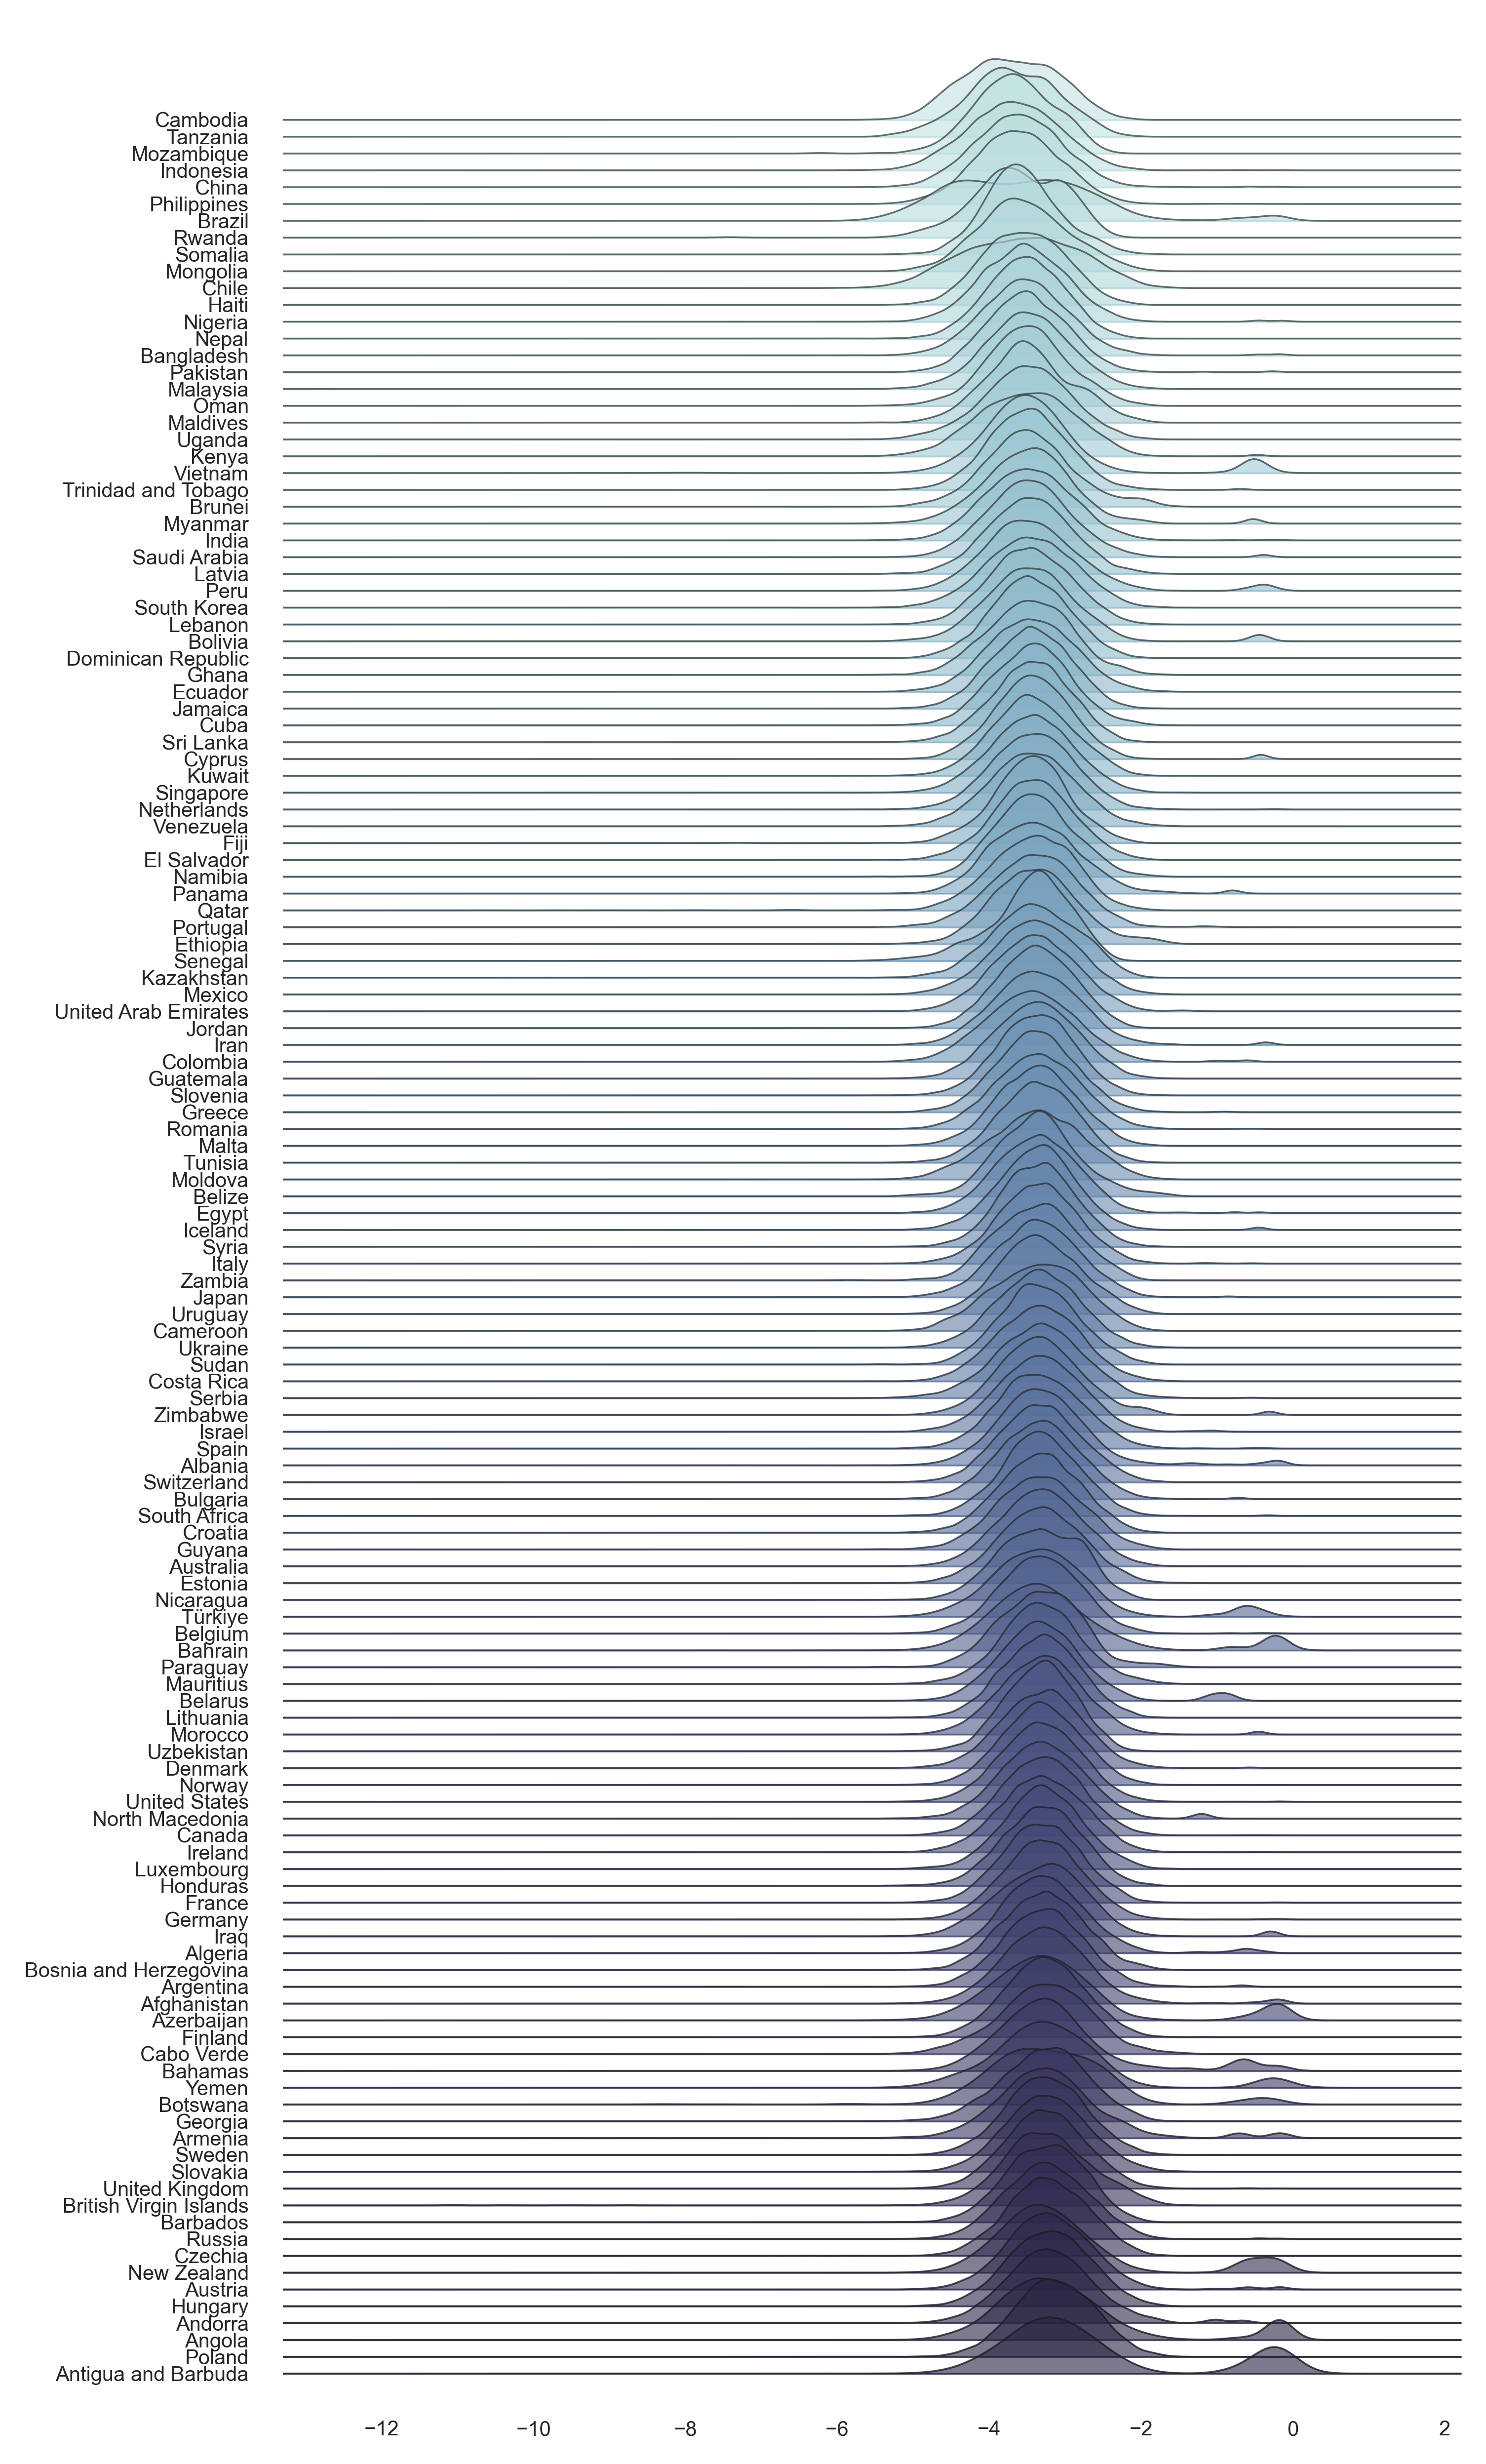

In [294]:
from joypy import joyplot
sns.set(font_scale=0.5)
sns.set_style("white")
plt.figure(dpi=500)
fig, axes = joyplot(country_dict, colormap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), figsize=(6,10), linewidth = 0.5, alpha = 0.6)
for ax in axes:
    label = ax.get_yticklabels()
    ax.set_yticklabels(label, fontdict={'size': 6})

plt.show()

# Supplement Information

## SI Figure 4

In [687]:
magic_countries = ['Argentina', 'Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Chile', 'China', 
                   'Colombia', 'Costa Rica', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 
                   'Greece', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Japan', 
                   'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 
                   'Poland', 'Portugal', 'Russia', 'Saudi Arabia', 'Slovakia', 'Slovenia', 'South Africa', 
                   'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Türkiye', 'United Kingdom', 'United States']
len(magic_countries)

46

In [689]:
df_magic_input = df_avg_input[df_avg_input['COUNTRY'].isin(magic_countries)]
print (df_magic_input.shape)

df_magic_regression = df_regression[df_regression['COUNTRY'].isin(magic_countries)]
print (df_magic_regression.shape)

(46, 22)
(46, 22)


In [690]:
feature_y = 'eco_feature1'
feature_x = 'personality_index'
linear_model = smf.ols('{0} ~ {1}'.format(feature_y, feature_x), data=df_magic_regression).fit()
para_model = smf.ols('{0} ~ {1} + I(-{1}**2)'.format(feature_y, feature_x), data=df_magic_regression).fit()

x = np.arange(df_magic_regression[feature_x].min(), df_magic_regression[feature_x].max(), 0.0001)

y_linear = [linear_model.params['Intercept'] + linear_model.params['personality_index'] * i for i in x]

y_para = [para_model.params['Intercept'] + para_model.params['personality_index'] * i - (para_model.params['I(-personality_index ** 2)'] * i**2) for i in x]

df_linear = pd.DataFrame([x, y_linear]).transpose()
df_linear.columns = [feature_x, 'linear_y']
df_para = pd.DataFrame([x, y_para]).transpose()
df_para.columns = [feature_x, 'para_y']


In [691]:
print ("R-squared of Linear model: {0}".format(linear_model.rsquared))
print ("p-value of Linear model: {0}".format(linear_model.f_pvalue))

print ("R-squared of Parabolic model: {0}".format(para_model.rsquared))
print ("p-value of Parabolic model: {0}".format(para_model.f_pvalue))

R-squared of Linear model: 0.3327373141523522
p-value of Linear model: 2.7161154773760455e-05
R-squared of Parabolic model: 0.44636080620086693
p-value of Parabolic model: 3.0156212333957285e-06


In [693]:
fig = px.scatter(df_magic_regression, x=feature_x, y=feature_y, text = 'COUNTRY', log_x=True, 
                 template = 'simple_white', trendline="ols", color_discrete_sequence = ['grey'], 
                 trendline_color_override = 'blue', 
                 labels={
                     feature_x: "Personality Diversity Index",
                     feature_y: "ln GDP per person employed (constant 2005-2023 PPP $)"
                 }, width=700, height=500)

fig.add_traces(px.line(df_para, x=feature_x, y="para_y", template = 'simple_white', color_discrete_sequence = ['red']).data)
# fig = px.line(df_para, x=feature_x, y="para_y", template = 'simple_white', color_discrete_sequence = ['red'])
fig.update_traces(textposition='top center')
fig.update_layout(
#     xaxis=dict(gridcolor='lightgrey'),
    margin=dict(r=0, b=0, t = 0, l=0 ,pad=0)
)
fig.show()
fig.write_image("magic_country_regression.pdf")

In [695]:
all_africa_country_list = ['South Africa', 'Egypt', 'Kenya', 'Nigeria', 'Algeria', 'Morocco', 'Uganda', 
                           'Zimbabwe', 'Angola', 'Tunisia', 'Ghana', 'Mauritius', 'Ethiopia', 'Sudan', 
                           'Tanzania', 'Cameroon', 'Namibia', 'Somalia', 'Botswana', 'Senegal', 'Zambia', 
                           'Mozambique', 'Rwanda', 'Cabo Verde']
len(all_africa_country_list)

df_africa_input = df_avg_input[df_avg_input['COUNTRY'].isin(all_africa_country_list)]
print (df_africa_input.shape)

df_africa_regression = df_regression[df_regression['COUNTRY'].isin(all_africa_country_list)]
print (df_africa_regression.shape)

(24, 22)
(24, 22)


In [696]:
feature_y = 'eco_feature1'
feature_x = 'personality_index'
linear_model = smf.ols('{0} ~ {1}'.format(feature_y, feature_x), data=df_africa_regression).fit()
para_model = smf.ols('{0} ~ {1} + I(-{1}**2)'.format(feature_y, feature_x), data=df_africa_regression).fit()

x = np.arange(df_africa_regression[feature_x].min(), df_africa_regression[feature_x].max(), 0.0001)

y_linear = [linear_model.params['Intercept'] + linear_model.params['personality_index'] * i for i in x]

y_para = [para_model.params['Intercept'] + para_model.params['personality_index'] * i - (para_model.params['I(-personality_index ** 2)'] * i**2) for i in x]

df_linear = pd.DataFrame([x, y_linear]).transpose()
df_linear.columns = [feature_x, 'linear_y']
df_para = pd.DataFrame([x, y_para]).transpose()
df_para.columns = [feature_x, 'para_y']


In [697]:
print ("R-squared of Linear model: {0}".format(linear_model.rsquared))
print ("p-value of Linear model: {0}".format(linear_model.f_pvalue))

print ("R-squared of Parabolic model: {0}".format(para_model.rsquared))
print ("p-value of Parabolic model: {0}".format(para_model.f_pvalue))

R-squared of Linear model: 0.4485185839129714
p-value of Linear model: 0.00034407252152039236
R-squared of Parabolic model: 0.46049671045920193
p-value of Parabolic model: 0.0015343979841555848


In [699]:
fig = px.scatter(df_africa_regression, x=feature_x, y=feature_y, text = 'COUNTRY', log_x=True, 
                 template = 'simple_white', trendline="ols", color_discrete_sequence = ['grey'], 
                 trendline_color_override = 'blue', 
                 labels={
                     feature_x: "Personality Diversity Index",
                     feature_y: "ln GDP per person employed (constant 2005-2023 PPP $)"
                 }, width=700, height=500)

fig.add_traces(px.line(df_para, x=feature_x, y="para_y", template = 'simple_white', color_discrete_sequence = ['red']).data)
# fig = px.line(df_para, x=feature_x, y="para_y", template = 'simple_white', color_discrete_sequence = ['red'])
fig.update_traces(textposition='top center')
fig.update_layout(
#     xaxis=dict(gridcolor='lightgrey'),
    margin=dict(r=0, b=0, t = 0, l=0 ,pad=0)
)
fig.show()
fig.write_image("africa_country_regression.pdf")

## SI Figure 3

In [703]:
%%time
ks_res_list = []
for country_x in country_diversity_order_list:
    print (country_x)
    country_x_sample = df_pairwise_samples[df_pairwise_samples['COUNTRY'] == country_x]['trans_cosine_distance'].tolist()
    for country_y in country_diversity_order_list:
        row_dict = {}
        row_dict['COUNTRY1'] = country_x
        row_dict['COUNTRY2'] = country_y
        country_y_sample = df_pairwise_samples[df_pairwise_samples['COUNTRY'] == country_y]['trans_cosine_distance'].tolist()
        
        res = stats.ks_2samp(country_x_sample, country_y_sample)
        row_dict['KS_Statistic'] = res[0]
        row_dict['p_value'] = res[1]
        ks_res_list.append(row_dict)
        
df_ks_res = pd.DataFrame(ks_res_list)
df_ks_map = pd.pivot_table(df_ks_res, values='p_value', index=['COUNTRY1'], columns=['COUNTRY2'])
df_ks_map = df_ks_map.loc[country_diversity_order_list, country_diversity_order_list]

Cambodia
Tanzania
Mozambique
Indonesia
China
Philippines
Brazil
Rwanda
Somalia
Mongolia
Chile
Haiti
Nigeria
Nepal
Bangladesh
Pakistan
Malaysia
Oman
Maldives
Uganda
Kenya
Vietnam
Trinidad and Tobago
Brunei
Myanmar
India
Saudi Arabia
Latvia
Peru
South Korea
Lebanon
Bolivia
Dominican Republic
Ghana
Ecuador
Jamaica
Cuba
Sri Lanka
Cyprus
Kuwait
Singapore
Netherlands
Venezuela
Fiji
El Salvador
Namibia
Panama
Qatar
Portugal
Ethiopia
Senegal
Kazakhstan
Mexico
United Arab Emirates
Jordan
Iran
Colombia
Guatemala
Slovenia
Greece
Romania
Malta
Tunisia
Moldova
Belize
Egypt
Iceland
Syria
Italy
Zambia
Japan
Uruguay
Cameroon
Ukraine
Sudan
Costa Rica
Serbia
Zimbabwe
Israel
Spain
Albania
Switzerland
Bulgaria
South Africa
Croatia
Guyana
Australia
Estonia
Nicaragua
Türkiye
Belgium
Bahrain
Paraguay
Mauritius
Belarus
Lithuania
Morocco
Uzbekistan
Denmark
Norway
United States
North Macedonia
Canada
Ireland
Luxembourg
Honduras
France
Germany
Iraq
Algeria
Bosnia and Herzegovina
Argentina
Afghanistan
Azerbaijan


In [713]:
fig, ax = plt.subplots(figsize=(35,30))
p1 = sns.heatmap(df_ks_map, cmap='Blues', ax=ax)
plt.xlabel('')
plt.ylabel('')

Text(1985.75, 0.5, '')

## SI Figure 5

In [21]:
from matplotlib.ticker import PercentFormatter

df_usa_entre_pred = pd.read_csv('outputFiles/44k_US_Personality_Diversity_Underlying_Data.csv')
df_usa_entre_pred['Entre_Proba'] = df_usa_entre_pred['Proba'].apply(lambda x: 1-x)
df_usa_entre_pred['Types'] = df_usa_entre_pred['Hierarchical label 8 clusters'].apply(lambda x: str(x).replace('0','Pioneer').replace('1','Translator').replace('2','Pathfinder').replace('3','Advisor').replace('4','Yearner').replace('5','Leader').replace('6','Uniter').replace('7','Strategist'))


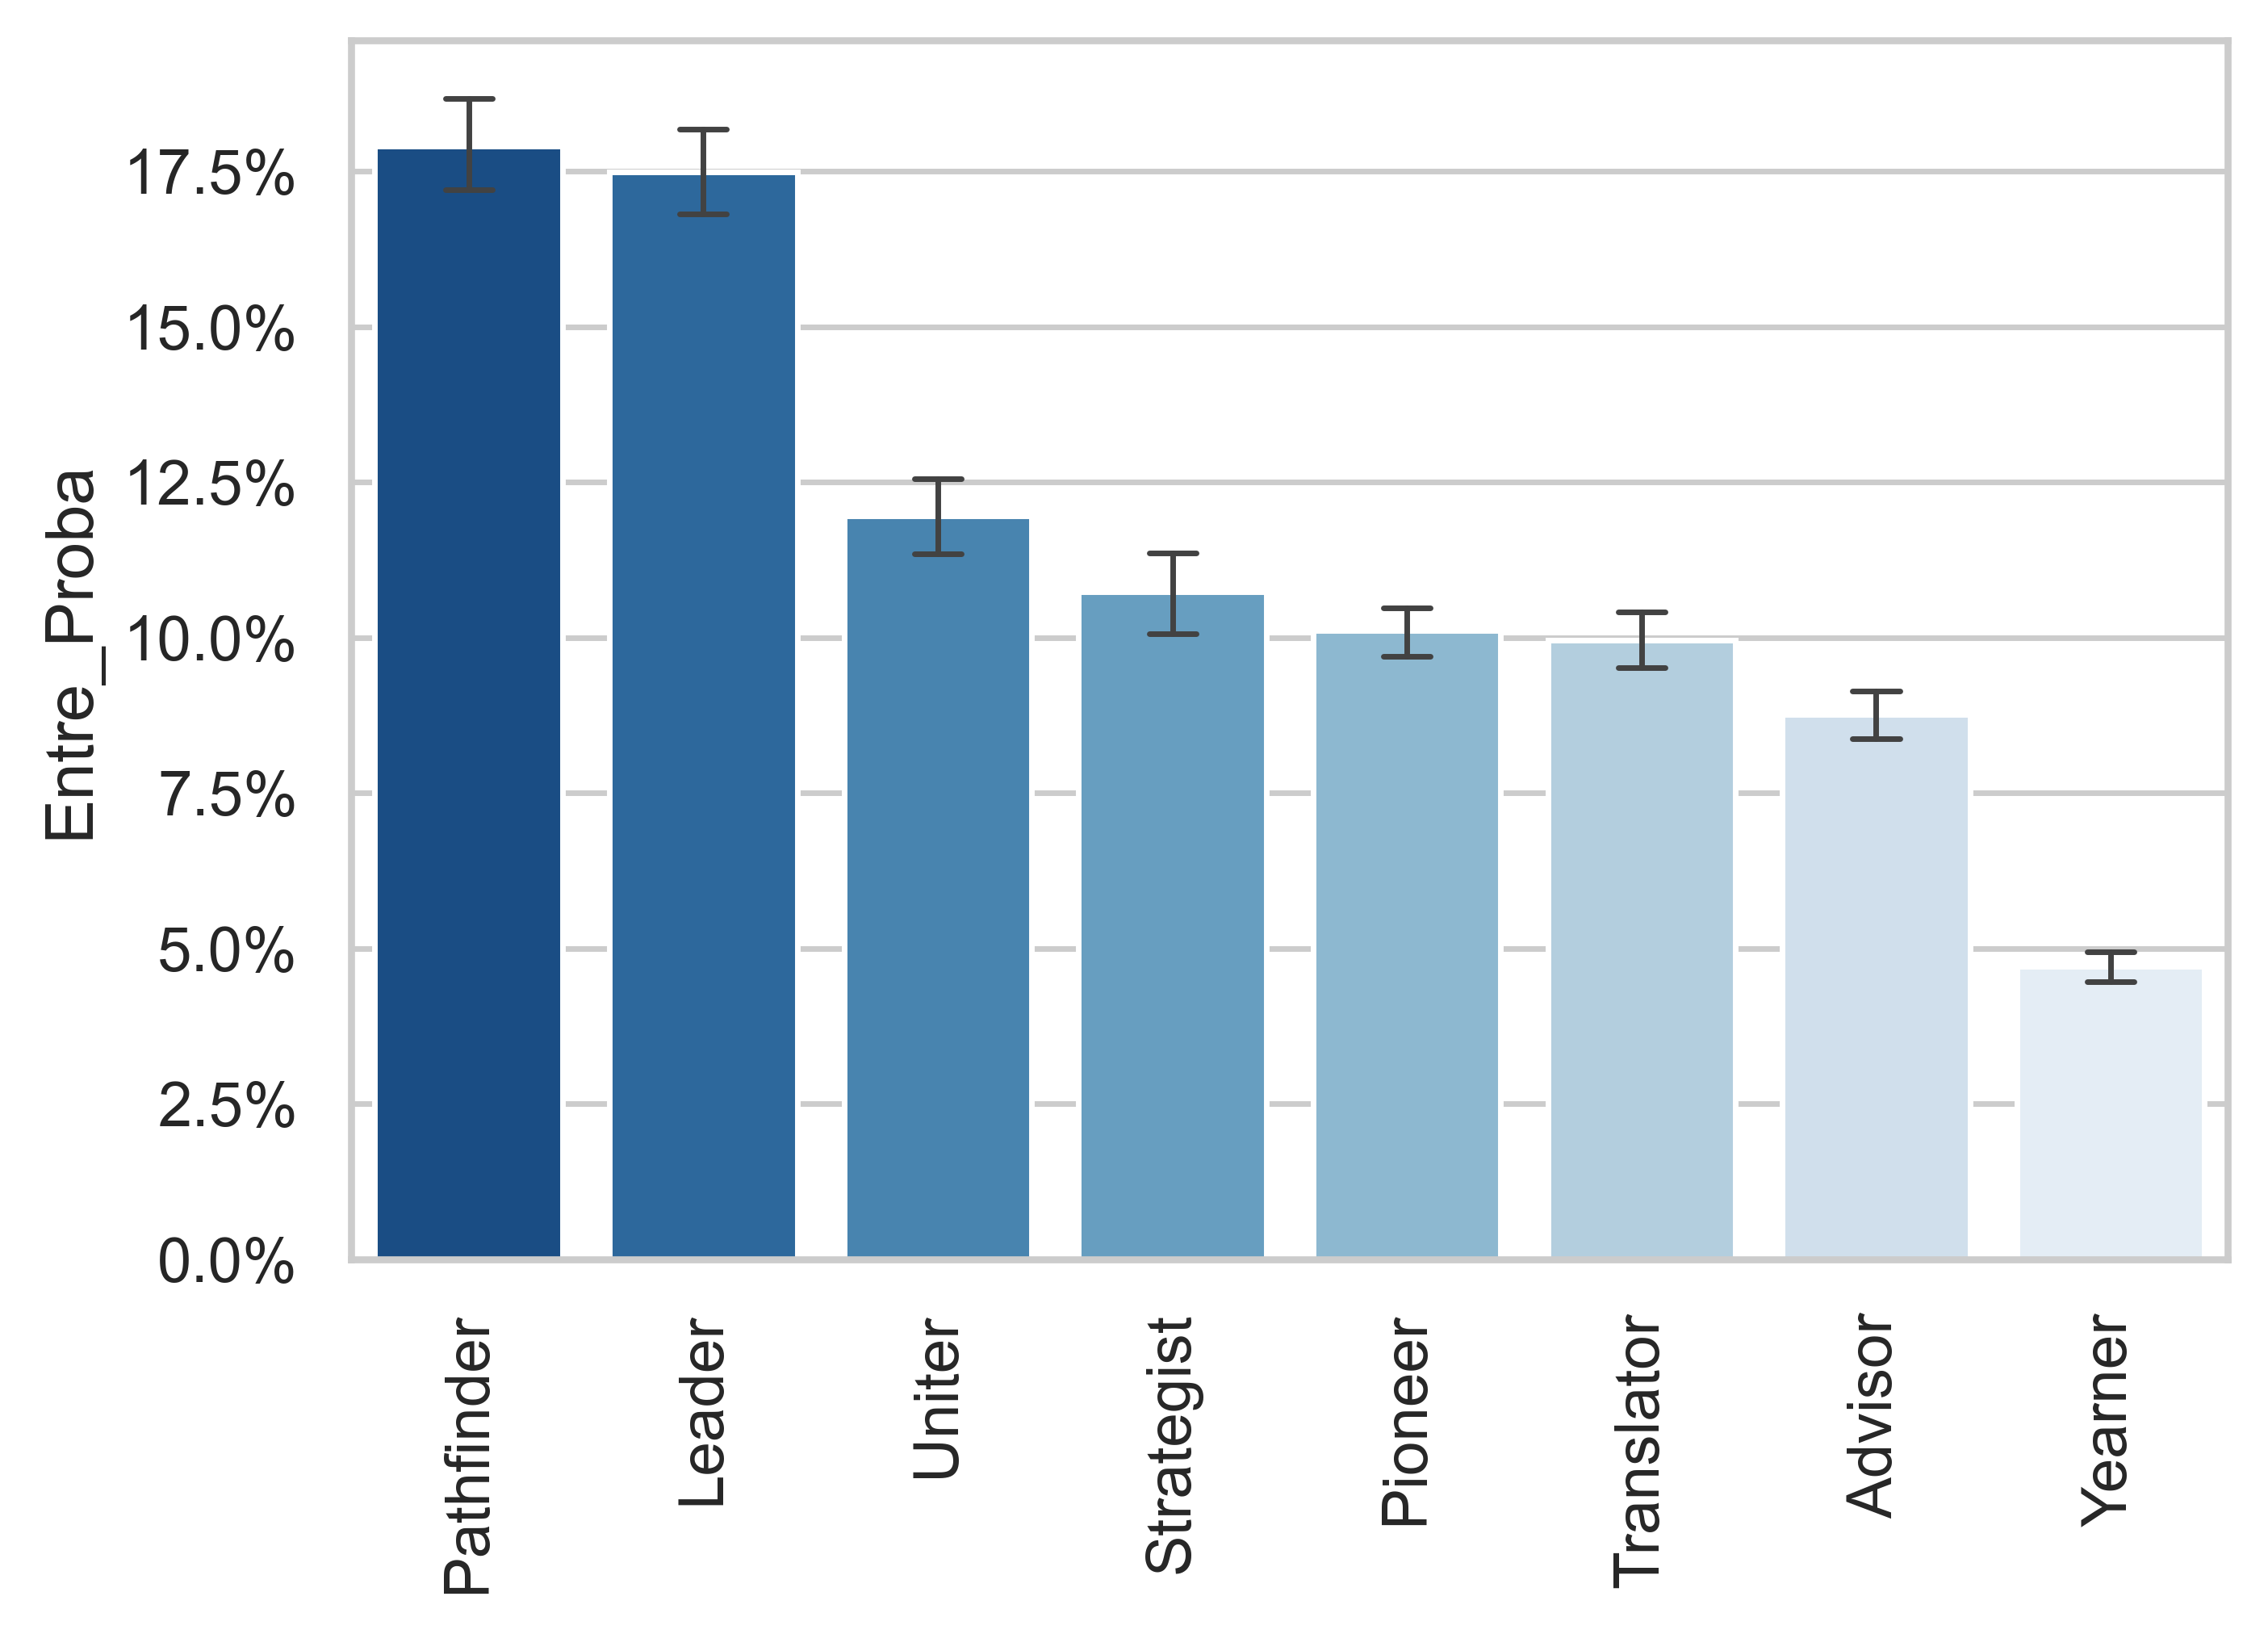

In [70]:
sns.set(font_scale = 0.1)
sns.set_theme(style="whitegrid", color_codes=True)
# pal = sns.color_palette("ch:s=.25,rot=-.25", df_usa_entre_pred['Types'].value_counts().shape[0])
pal = sns.color_palette("Blues", df_usa_entre_pred['Types'].value_counts().shape[0])
ax = sns.barplot(x="Types", y="Entre_Proba", data = df_usa_entre_pred, estimator=np.mean, ci=95, capsize=.2, order = ['Pathfinder', 'Leader', 'Uniter', 'Strategist', 'Pioneer', 'Translator', 'Advisor', 'Yearner'], palette = pal[::-1], errwidth=1)
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=90, 
                   horizontalalignment='center')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
fig = ax.get_figure()
fig.savefig("entreprenuer_probability.pdf", bbox_inches='tight', dpi = 1200)